In [1]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [2]:
import numpy as np
from graph.structure.graph import Graph
from graph.prior.sparse_prior import SparsePrior
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.measurement.masked_gaussian_measurement import MaskedGaussianMeasurement
from core.metrics import mse
from core.linalg_utils import random_binary_mask

In [3]:
# ==== 1. パラメータ設定 ====
H, W = 128,128
rho = 0.1
var = 1e-4
mask_ratio = 0.2
rng = np.random.default_rng(seed=42)

# ==== 2. モデル定義（Prior → FFT2D → MaskedGaussian） ====
class FFT2DTestGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = SparsePrior(rho=rho, shape=(H, W), damping = 0.03)
        self.Y = FFT2DPropagator(shape=(H, W)) @ self.X
        mask = random_binary_mask((H, W), subsampling_rate=mask_ratio, rng=rng)
        self.Z = MaskedGaussianMeasurement(self.Y, var=var, mask=mask)
        self.compile()

In [4]:
# ==== 3. グラフ構築 ====
g = FFT2DTestGraph()

# ==== 4. サンプル生成 ====
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=24))

true_x = g.X.get_sample()
observed = g.Z.get_sample()

In [5]:
# ==== 5. 推論実行 ====
def monitor(graph, t):
    est = graph.X.compute_belief().data
    err = mse(est, true_x)
    if t % 5 == 0:
        print(f"[t={t}] MSE = {err:.5e}")

g.run(n_iter=40, callback=monitor)

# ==== 6. 結果表示 ====
final_est = g.X.compute_belief().data
print(f"Final MSE after 30 iterations: {mse(final_est, true_x):.5e}")

[t=0] MSE = 6.93657e-01
[t=5] MSE = 3.01533e-02
[t=10] MSE = 1.21982e-02
[t=15] MSE = 2.53604e-03
[t=20] MSE = 4.29865e-04
[t=25] MSE = 2.71994e-04
[t=30] MSE = 2.86113e-04
[t=35] MSE = 2.85656e-04
Final MSE after 30 iterations: 2.91738e-04


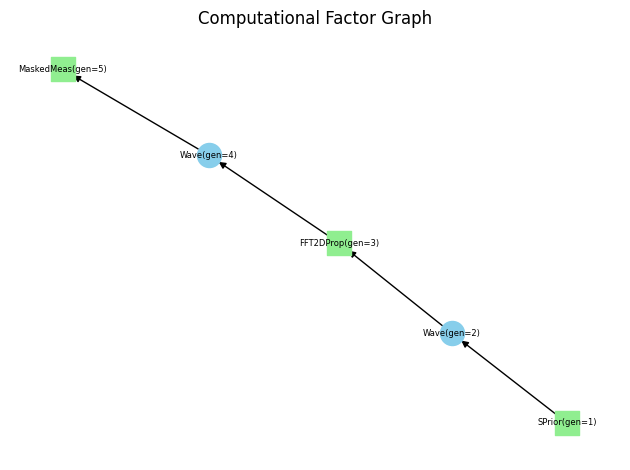

In [6]:
g.visualize(layout="kamada_kawai", font_size=6, scale=2.0)

In [7]:
import numpy as np
from core.metrics import mse
from core.linalg_utils import random_binary_mask, random_phase_mask
from graph.structure.graph import Graph
from graph.prior.sparse_prior import SparsePrior
from graph.propagator.phase_mask_propagator import PhaseMaskPropagator
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.measurement.masked_gaussian_measurement import MaskedGaussianMeasurement

# ==== 1. パラメータ設定 ====
H, W = 128, 128
shape = (H, W)
rho = 0.1
var = 1e-4
mask_ratio = 0.2
rng = np.random.default_rng(seed=21)

# ==== 2. グラフ定義 ====
class PhaseMaskedCSGraph(Graph):
    def __init__(self):
        super().__init__()

        self.X = SparsePrior(rho=rho, shape=shape, damping=0.03)

        phase_mask = random_phase_mask(shape, rng=rng)
        self.Y = PhaseMaskPropagator(phase_mask) @ self.X

        self.F = FFT2DPropagator(shape=shape) @ self.Y

        mask = random_binary_mask(shape, subsampling_rate=mask_ratio, rng=rng)
        self.Z = MaskedGaussianMeasurement(self.F, var=var, mask=mask)

        self.compile()

# ==== 3. インスタンス生成と初期化 ====
g = PhaseMaskedCSGraph()
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=35))

true_x = g.X.get_sample()
observed = g.Z.get_sample()

# ==== 4. 推論 ====
def monitor(graph, t):
    est = graph.X.compute_belief().data
    err = mse(est, true_x)
    if t % 5 == 0:
        print(f"[t={t}] MSE = {err:.5e}")

g.run(n_iter=40, callback=monitor)

# ==== 5. 結果表示 ====
final_est = g.X.compute_belief().data
print(f"Final MSE after 30 iterations: {mse(final_est, true_x):.5e}")

[t=0] MSE = 6.90166e-01
[t=5] MSE = 2.90461e-02
[t=10] MSE = 9.31264e-03
[t=15] MSE = 1.40075e-03
[t=20] MSE = 2.96815e-04
[t=25] MSE = 2.68347e-04
[t=30] MSE = 2.73216e-04
[t=35] MSE = 2.74195e-04
Final MSE after 30 iterations: 2.74374e-04


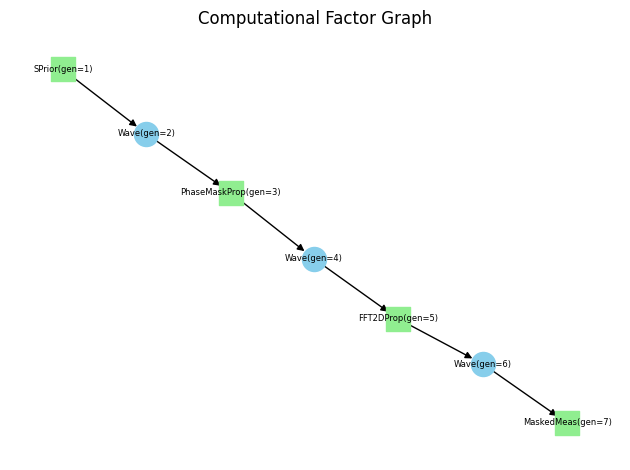

In [8]:
g.visualize(layout="kamada_kawai", font_size=6, scale=2.0)